# Выполнение домашнего задания №5 для OTUS

In [1]:
## Спланировать эксперимент

# 1. Составить первичный список признаков, необходимых для решения задачи
# 2. Сгенерировать список новых признаков, которые можно получить из данных
# 3. Применить понижение размерности для визуализации данных
# 4. Применить кластеризацию, визуализировать
# 5. Описание кластера
# 6. Любые другие пункты

## Выполнить подготовку данных для построения модели
## Провести построение модели
## Проанализировать результат
## Повторить при необходимости

In [4]:
import pandas as pd
import numpy as np

hd_data = pd.read_csv('Datasets/plantar_disease_dataset.csv')

# Удалим ненужное поле ID
def remove_id_field(df):
    return df.drop(['id'], axis=1)

# Нормализацию решил не делать (тоесть все фичи приводить к значениям (0;1)) пользы не приносит.
# Это уже 3 дата сет. В предыдущие попытки проверял - точность модели выше не становится.
hd_data = remove_id_field(hd_data)

In [104]:
# Описание

# age - Nuff said
# sex - 1 - мужчина, 0-женщина
# weight - Вес в киллограммах
# hoursRunInAWeeklong - Продолжительность бега на длинные дистанции
# highHealWear - Ношение обуви с высоким каблуком
# multipleJointPains - Боли в ступне. Могут быть связанн с артриток
# allignmentOfMidFoot - Подъём. 0 - обычный, 1 - высокий, 2 - плоскостопие
# diabete - Диабет, фактор риска
# cyanosisskin - Цианоз кожи
# burningSensationInPS - Ощущение жжения
# Tenderness - Болезненность при прикосновении к костям ног (Не понял что это значит. Оригинал "Tenderness to palpation over the tibia, fibula, malleoli, tarsals, metatarsals, metacarpophalangea")
# StatusPlantar - Наличие заболевания. 1 - есть, 0 - нет.

# Общее количество - 12 колонок.
# Датасет - результаты анализов крови пациентов с заболеваниями печени.


In [5]:
# Посмотрим на данные из дата сета
pd.set_option('display.expand_frame_repr', False)
print(hd_data.iloc[10:20])

    age  sex  weight  hoursRunInAWeek  highHealWear  multipleJointPains  allignmentOfMidFoot  diabetes  cyanosis  burningSensationInPS  Tenderness  Status
10   51    0      52                0             0                   0                    0         1         0                     1           0       1
11   53    0      53                1             0                   0                    0         1         0                     1           1       0
12   42    0      59                2             0                   0                    0         1         1                     0           0       0
13   57    0      67                2             0                   0                    0         1         1                     0           1       1
14   48    0      62                0             0                   0                    0         1         1                     1           0       1
15   52    0      51                3             0                   

In [74]:
# Первым делом посмотрим коррелированность различных атрибутов

correlation = hd_data.corr(method='pearson')
print(correlation)

def find_max_abs_values_by_columns(df):
    max_values = dict()
    columns = df.columns.tolist()
    for column in columns:
        max_value = np.max(np.absolute(df.get(column).tolist()))
        max_values[column] = max_value

    return max_values

# Удалим из данных корреляцию с самим собой.
def zero_self_correlation(df):
    data_frame = df.copy(deep=False)
    columns = data_frame.columns.tolist()
    for column in columns:
        data_frame[column][column] = 0.0
    return data_frame

print('\nМаксимальная корреляция по атрибутам\n')
print(find_max_abs_values_by_columns(zero_self_correlation(correlation)))

# Найдены сильно коррелирующие атрибуты:
# age <-> diabetes - 0.7559180503984493
# weight <-> status - 0.5850814093473641
# weight <-> diabetes - 0.567181
# hoursRunInAWeek <-> age - -0.33446684119559406 # Вполне очевидно что чем старше человек, тем меньше он бегает :D
# multipleJointPains <-> age - 0.37001500084893696
# diabetes <-> Status - 0.555043

                           age       sex    weight  hoursRunInAWeek  highHealWear  multipleJointPains  allignmentOfMidFoot  diabetes  cyanosis  burningSensationInPS  Tenderness    Status
age                   1.000000 -0.006708  0.414974        -0.334467      0.008121            0.370015             0.011459  0.755918 -0.050842              0.012004    0.010592  0.532696
sex                  -0.006708  1.000000  0.024343        -0.007217      0.000000            0.000000             0.000000  0.000000  0.000000              0.000000    0.000000 -0.216175
weight                0.414974  0.024343  1.000000        -0.185178     -0.009737           -0.003408             0.471946  0.567181  0.039922              0.007303   -0.020935  0.585081
hoursRunInAWeek      -0.334467 -0.007217 -0.185178         1.000000      0.012028           -0.226129            -0.301994 -0.199667  0.009623             -0.007217   -0.012028 -0.191598
highHealWear          0.008121  0.000000 -0.009737         0.0120

In [75]:
# Восползуемся логистической регрессией с L1 регуляризацией
import sklearn.metrics as smt
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()

# Вспомогательные функции
def quality(standard, predicted):
    return smt.adjusted_rand_score(standard, predicted)

def remove_columns(df, columns):
    return df.drop(columns, axis=1)

def copy_data_set(df):
    return df.copy(deep=False)

def print_columns_coefficients(classifier, dataset):
    columns = dataset.columns.tolist()
    coefficients = classifier.coef_[0]
    result = {}
    for index in range(len(columns)):
        result[columns[index]] = coefficients[index]
    print('Коэффициенты:')
    print(result)
    return

def perform_regression(data, title, **regression_params):
    x_values = copy_data_set(data)
    y_standard = x_values.get('Status').tolist()
    x_values = remove_columns(x_values, ['Status'])
    clf = LogisticRegression(**regression_params)
    clf = clf.fit(x_values, y_standard)

    y_pred = clf.predict(x_values)

    print('{0} {1}'.format(title, quality(y_standard, y_pred)))
    print_columns_coefficients(clf, x_values)
    return

# To avoid ValueError: Unknown label type: 'continuous'
def label_encoder(collection):
    return lab_enc.fit_transform(collection)

In [122]:
# Оценим качество

perform_regression(hd_data, 'Точность модели без модификаций', penalty='l1', solver='liblinear', C=3, class_weight={0: 2, 1: 1})

Точность модели без модификаций 0.7318675358755893
Коэффициенты:
{'age': 0.2964973886261332, 'sex': -3.86492933118875, 'weight': 0.2591184076155807, 'hoursRunInAWeek': -1.0941285520237694, 'highHealWear': 0.23856754497638422, 'multipleJointPains': -0.6574631531230811, 'allignmentOfMidFoot': 0.05592358949365352, 'diabetes': 0.00824384008120101, 'cyanosis': -0.551084906070216, 'burningSensationInPS': -0.13571027386384837, 'Tenderness': -0.10880563472268182}


In [108]:
# Найдём максимальные значения по колонкам. Сильного разброса нет
def find_max_abs_values_by_columns(df):
    max_values = dict()
    columns = df.columns.tolist()
    for column in columns:
        max_value = np.max(df.get(column).tolist())
        max_values[column] = max_value

    return max_values

max_values_dict = find_max_abs_values_by_columns(hd_data)
print('Max values dict {0}'.format(max_values_dict))

Max values dict {'age': 60, 'sex': 1, 'weight': 85, 'hoursRunInAWeek': 12, 'highHealWear': 1, 'multipleJointPains': 1, 'allignmentOfMidFoot': 2, 'diabetes': 1, 'cyanosis': 1, 'burningSensationInPS': 1, 'Tenderness': 1, 'Status': 1}


In [121]:
# Оценим качество
optimised_data_set = copy_data_set(hd_data)
optimised_data_set = remove_columns(optimised_data_set, ['highHealWear', 'cyanosis', 'burningSensationInPS', 'Tenderness', 'diabetes'])

perform_regression(optimised_data_set, 'Точность модели без мало значимых колонок', penalty='l1', solver='liblinear', class_weight={0: 2, 1: 1}, C=3)

# Качество обучения не слишокм снизилось

Точность модели без мало значимых колонок 0.7213291042590997
Коэффициенты:
{'age': 0.3033157886180763, 'sex': -3.8662861448477432, 'weight': 0.24791236974164718, 'hoursRunInAWeek': -1.1095835368675186, 'multipleJointPains': -0.5974955462305177, 'allignmentOfMidFoot': 0.0924180880255388}


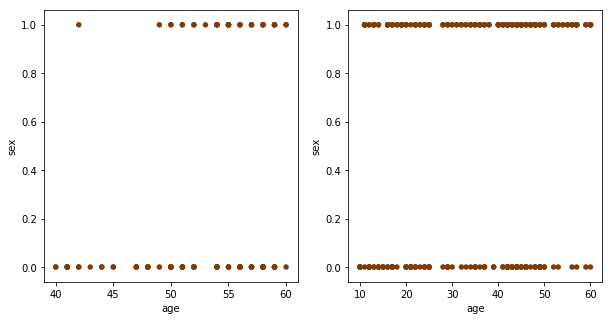

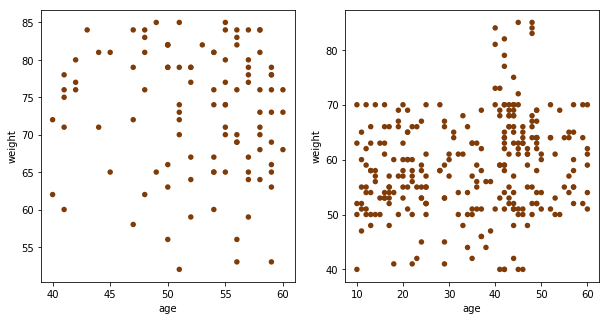

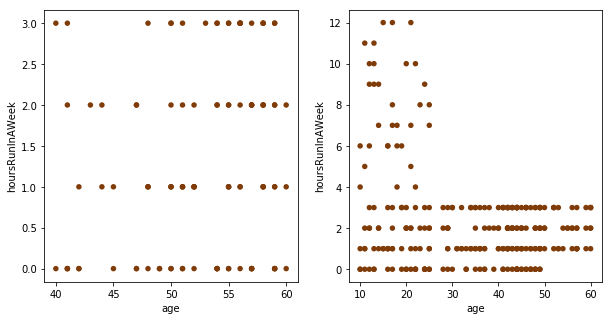

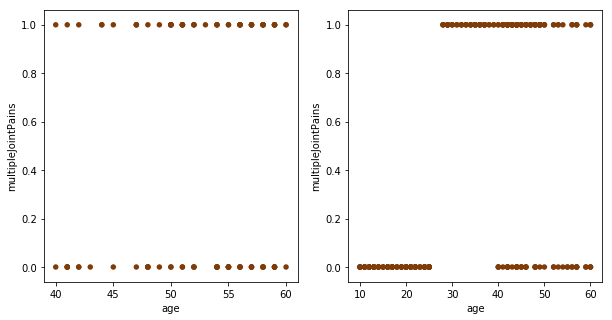

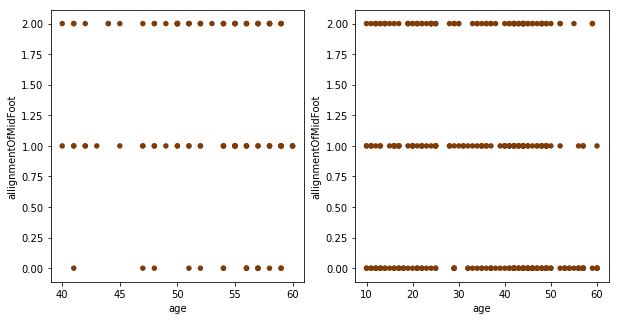

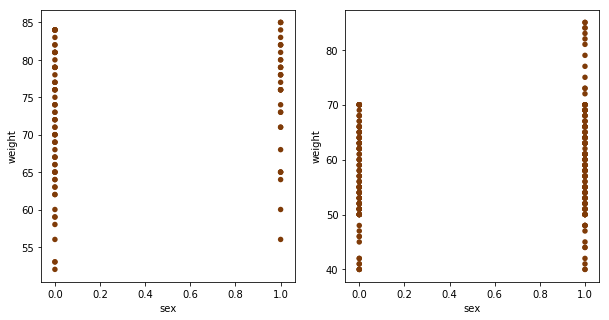

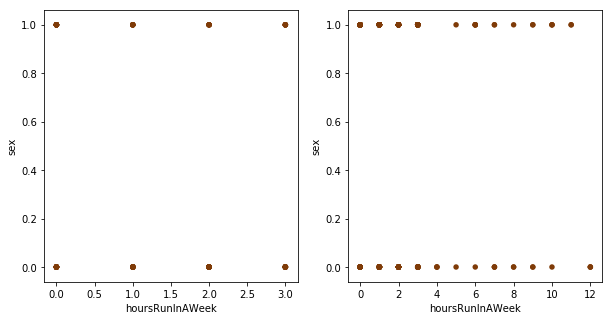

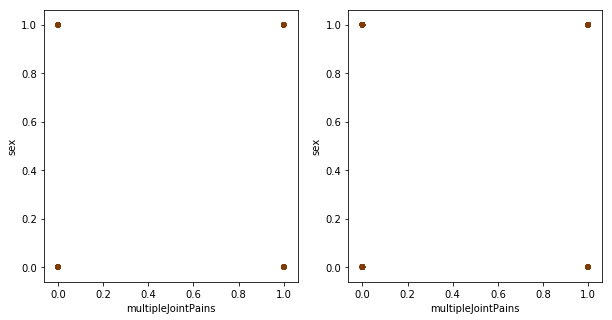

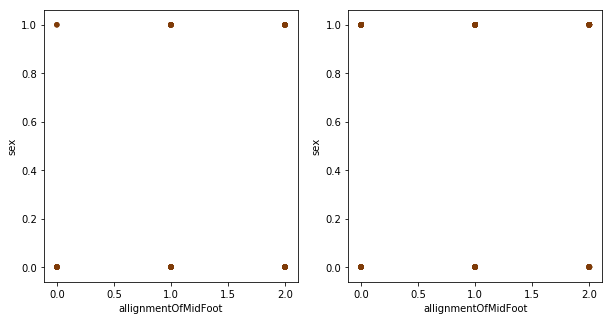

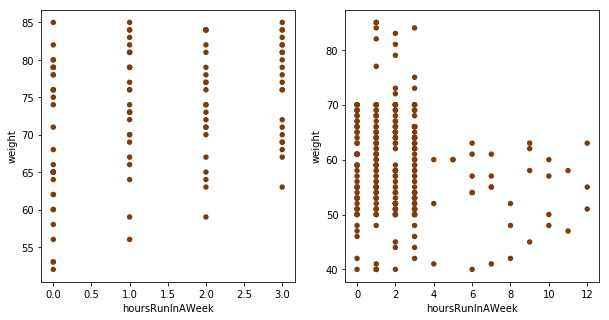

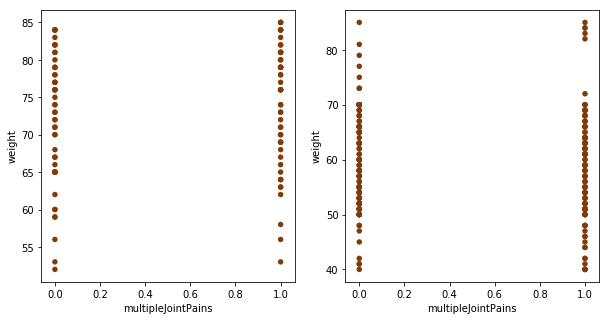

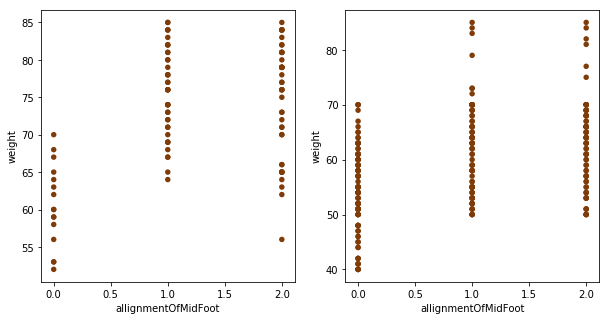

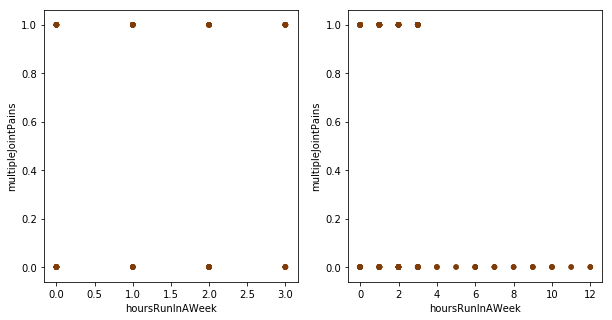

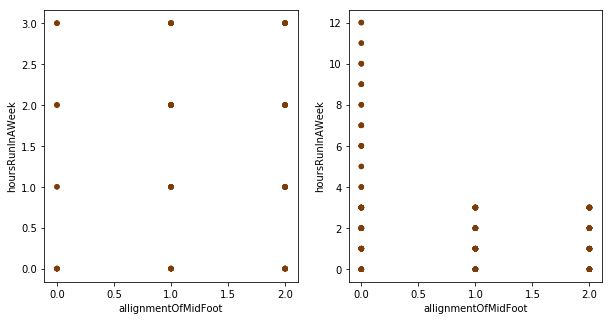

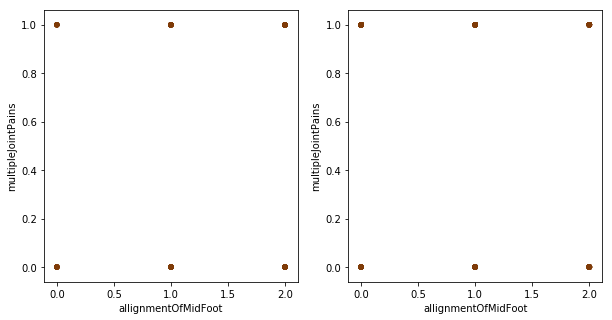

True

In [115]:
# Построим сравнительные визуализации для всех оставшихся полей
# Слева в графике - люди с заболеванием, справа - здоровые.
import matplotlib.pyplot as pl

def display_app_dimensions_combinations(data_frame, label_column):
    df = copy_data_set(data_frame)

    trues = df.loc[df[label_column] == 1]
    falses = df.loc[df[label_column] == 0]
    y_trues = np.ones(len(trues))
    y_falses = np.zeros(len(falses))

    df = remove_columns(df, [label_column])
    columns = df.columns

    columns_combinations = []

    for i in range(len(columns)):
        for j in range(len(columns)):
            el = [columns[i], columns[j]]
            el.sort()
            if (el in columns_combinations) or (columns[i] == columns[j]):
                continue
            else:
                columns_combinations += [el]

    for [first_column, second_column] in columns_combinations:
        pl.figure(figsize=(10, 5))

        pl.subplot(1, 2, 1)
        pl.scatter(trues.get(first_column).tolist(), trues.get(second_column).tolist(), c=y_trues, cmap=pl.cm.PuOr, lw=0, s=30)
        pl.xlabel(first_column)
        pl.ylabel(second_column)

        pl.subplot(1, 2, 2)
        pl.scatter(falses.get(first_column).tolist(), falses.get(second_column).tolist(), c=y_falses, cmap=pl.cm.PuOr, lw=0, s=30)
        pl.xlabel(first_column)
        pl.ylabel(second_column)
        pl.show()

    return True

display_app_dimensions_combinations(optimised_data_set, 'Status')

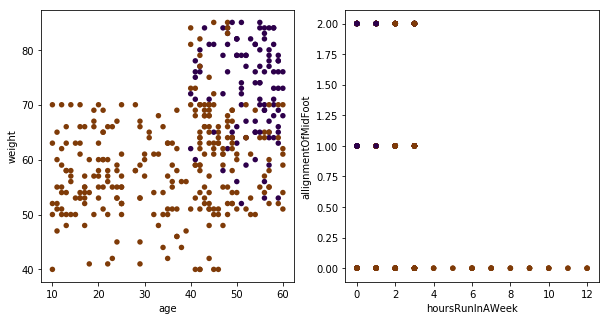

In [152]:
# Из выше перечисленных графиков заметно что есть кластеризация по показателям:
# weight - люди с заболеванием - имеют больший вес > 55 кг
# hoursRunInAWeek - люди с заболеванием - бегают меньше 3 часов в неделю
# age - люди с заболеванием женщины за 40 и мужчины за 50
# allignmentOfMidFoot - люди с высоким подъёмом или с плоскостопием немного чаще имеют пяточные шпоры. (Этим показателем можно принебречь.)

# Итак мы с помошью легуляризации отмели ненужные атрибуты, затем построили визуализацию и поняли по каким конкретно атрибутам данные сильнее всего расходятся.

# Изобразим на двух двухмерных графиках 4 этих фичи, отобразим на графиках одновременно больных и здоровых, чтобы увидить наличие кластеров.

def display_main_dimensions(df, y_labels=None):
    if y_labels is None:
        y_labels = df.get('Status').tolist()
    
    pl.figure(figsize=(10, 5))
    
    pl.subplot(1, 2, 1)
    pl.scatter(df.get('age').tolist(), df.get('weight').tolist(), c=y_labels, cmap=pl.cm.PuOr, lw=0, s=30)
    pl.xlabel('age')
    pl.ylabel('weight')
    
    pl.subplot(1, 2, 2)
    pl.scatter(df.get('hoursRunInAWeek').tolist(), df.get('allignmentOfMidFoot').tolist(), c=y_labels, cmap=pl.cm.PuOr, lw=0, s=30)
    pl.xlabel('hoursRunInAWeek')
    pl.ylabel('allignmentOfMidFoot')
    pl.show()
    
    return

display_main_dimensions(optimised_data_set)
# Видно явное наличие кластеров. При высоком подъёме или плоскостопии - чаще встречается наличие пяточных шпор.

# !!!!!!! 
# Задание выполнено. Но попробуем улучшить результат.
# На текущий момент лучший результат - классификация с помошью логистической регрессии - точность 0.7213291042590997
# Попробуем произвести кластеризацию.

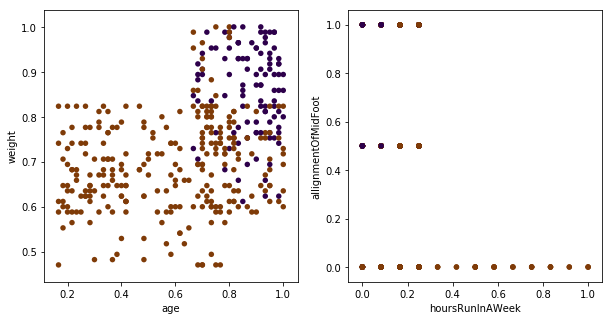

In [153]:
# Проведём нормализацию, чтобы можно было воспользоваться алгоритмом кластеризации (Да теперь воспользуемся, чтобы ещё раз подтвердить гипотезу, хотя в начале я писал что делалть этого не будем)

def find_max_values_by_columns(df):
    max_values = dict()
    columns = df.columns.tolist()
    for column in columns:
        max_value = np.max(df.get(column).tolist())
        max_values[column] = max_value

    return max_values

def normalize(data_frame):
    df = copy_data_set(data_frame)
    max_values_dict = find_max_values_by_columns(data_frame)
    for (column, max_value) in max_values_dict.items():
        df[column] = df[column] / max_value
    return df

normalized_data_set = normalize(optimised_data_set)

display_main_dimensions(normalized_data_set)

ClusterWard quality -0.0020520075173087043


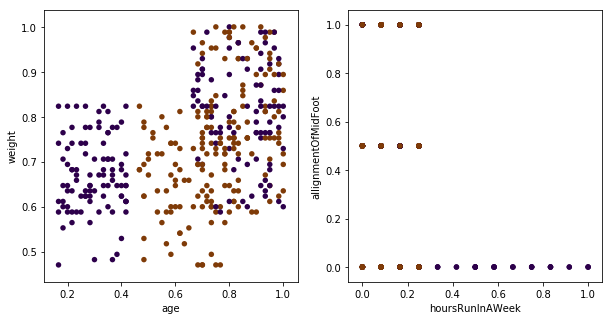

In [154]:
# Изучив алгоритмы кластеризации было принято решение использовать SpectralClustering, Ward, AgglomerativeClustering
# https://scikit-learn.org/stable/modules/clustering.html
import sklearn.cluster

def perform_clustering(cluster, df):
    clusterisation_set = copy_data_set(df)
    y = clusterisation_set.get('Status').tolist()
    x = remove_columns(clusterisation_set, ['Status'])
    y_pred = cluster.fit_predict(x)
    
    cluster.fit(x)
    print('ClusterWard quality {0}'.format(quality(y, y_pred)))

    display_main_dimensions(x, y_pred)

    return

clust = sklearn.cluster.AgglomerativeClustering(n_clusters=2, linkage='ward')

perform_clustering(clust, normalized_data_set)

# Результат неудачный. Не удивительно - кластеры распложены частично один в другом. 

ClusterWard quality -0.0020520075173087043


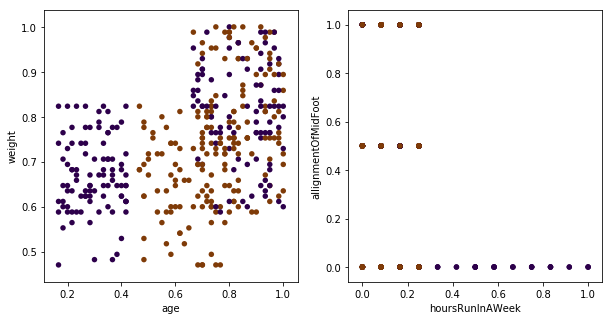

In [155]:
# Попробуем K-Means
clust = sklearn.cluster.KMeans(n_clusters=2, init='k-means++', n_init=10, algorithm='elkan')

perform_clustering(clust, normalized_data_set)
# Опять результат неудачный по той же причины. Вероятно кластеризация в данном случае вообще не применима.
# Очевидно и DBScan не подойдёт. И Optics. 
# Лучшее решение - логистическая регрессия.

# Заключение 
Было выполнено задание по уменьшению размерности дата сета.
Из 11 фич отфильтровано 4 наиболее важных и наглядных.
На визуализациях явно видно наличие кластеров, но произвести кластеризацию с помощью алгоритмов кластеризации сложно т.к. кластеры достаточно сильно взаимно проникли друг в друга.
Лучшая кластеризация с помошью логистической регрессии - точность ~ 0.7, с параметрами `LogisticRegression(penalty='l1', solver='liblinear', C=3, class_weight={0: 2, 1: 1})`.

Финальный дата сет 0.7213291042590997
Коэффициенты:
{'age': 0.29658463574884353, 'sex': -3.792438145144671, 'weight': 0.24243220786998212, 'hoursRunInAWeek': -1.0886965516103868, 'multipleJointPains': -0.5968328671432135, 'allignmentOfMidFoot': 0.09710144020669748}


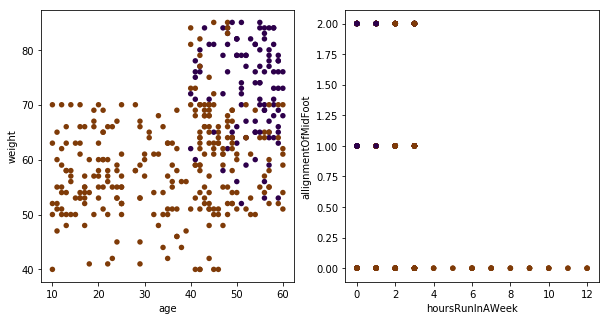

In [158]:
# В финале выведем достигнутые показатели
perform_regression(optimised_data_set, 'Финальный дата сет', penalty='l1', solver='liblinear', C=3, class_weight={0: 2, 1: 1})

display_main_dimensions(optimised_data_set)